# 3rd Study Case: Traffic Sign with Convolutional Neural Network

CNN: Traffic Sign Classification with OpenCV<br>
*Dataset German Traffic Sign*

Naufal Mu'afi<br>
nmuafi1@gmail.com

---

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1. Data Loading
---

In [ ]:
# if you work with Google Colab, please run this cell
# from google.colab import drive
# drive.mount('/content/drive')

## Load the data
# training_file = "/content/drive/MyDrive/Dataset/German Traffic Sign/train.p"
# testing_file = "/content/drive/MyDrive/Dataset/German Traffic Sign/test.p"   

In [4]:
# if you work with local, please run this cell
training_file = './data/train.p'
testing_file = './data/test.p'

In [5]:
# Open and load the training file 
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
 
# Open and load the testing file
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
print("Data loaded")

Data loaded


## 2. Exploratory Data Analysis (EDA)
---

First, read the signnames.csv that contains id and class name in the datasets.

In [7]:
sign_name_df = pd.read_csv('./data/signnames.csv')
SIGN_NAMES = sign_name_df.SignName.values
sign_name_df.set_index('ClassId', inplace=True)
sign_name_df.head(10)

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)


Next, define the features and the labels on the loaded pickle data then convert list to numpy array.

In [8]:
# define features and labels for training data
X, y = train['features'], train['labels']

# convert list to np array
data = np.array(X)
labels = np.array(y)
print(data.shape, labels.shape)

# define features and labels for testing data
X_test, y_test = test['features'], test['labels']

# convert list to np array
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape, y_test.shape)

(34799, 32, 32, 3) (34799,)
(12630, 32, 32, 3) (12630,)


afer that, split training data into train and val

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(31319, 32, 32, 3) (3480, 32, 32, 3) (31319,) (3480,)


Then, we can visualize class distribution of data training, validation, and testing.

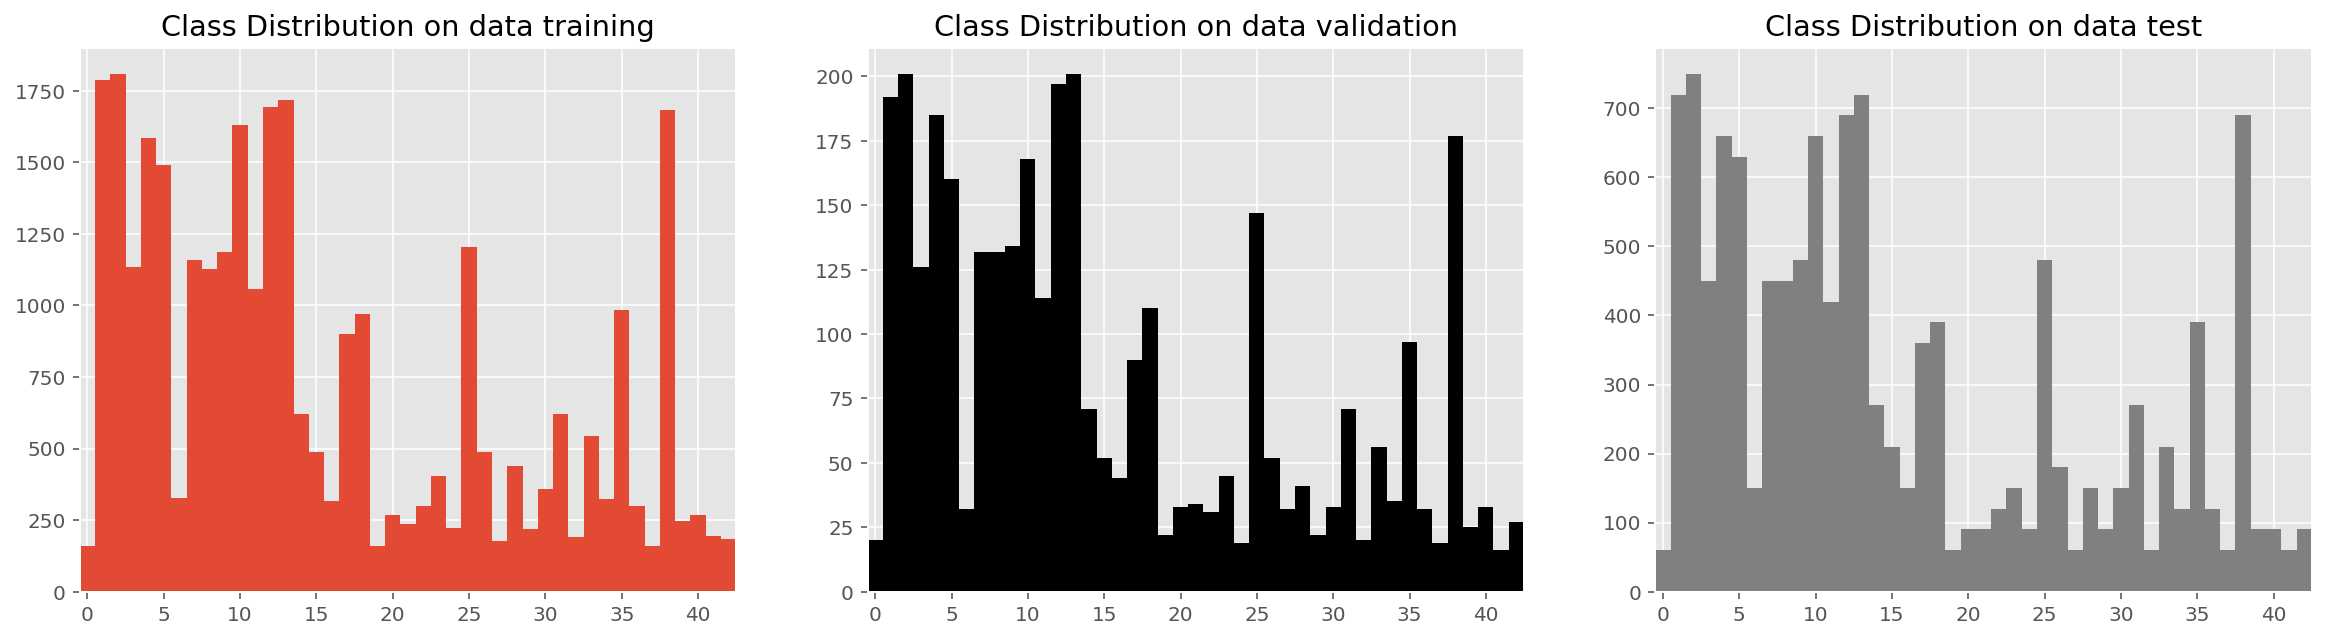

In [13]:
n_labels = np.unique(y_train).size

def hist_data(y_data, title=None, ax=None, **kwargs):
    if not ax :
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.hist(y_data, np.arange(-0.5, n_labels+1.5), stacked=True, **kwargs)
    ax.set_xlim(-0.5, n_labels-0.5)
    if 'label' in kwargs : ax.legend()
    if title : ax.set_title(title)
        
fig,ax = plt.subplots(1,3, figsize=(20,5))
hist_data(y_train, title='Class Distribution on data training', ax=ax[0])
hist_data(y_val, title='Class Distribution on data validation', ax=ax[1], color='black')
hist_data(y_test, title='Class Distribution on data test', ax=ax[2], color='grey')

Based on the plot above, it seems like the class distribution is looks similiar. Therefore, in this project, normalization or feature scaling is not needed.

## 3. Data Preparation
---

In this step, the label on training and validation data will be convert to categorical feature with One Hot Encoding technique. In this dataset, there're 43 class names.

In [14]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

## 4. Model Development and Training
---

### Callback

First, define a callback that stops model training when the model accuracy reachess 96%.

In [15]:
class Callback_96(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('accuracy') > 0.96):
      print(f"\nStopped! Accrucay is already reach 96%")
      self.model.stop_training = True

callbacks = Callback_96()

### Model Creation

In [17]:
model = Sequential([
  Conv2D(32, (5,5), activation='relu', input_shape=X_train.shape[1:]),
  Conv2D(32, (5,5), activation='relu'),
  MaxPool2D(2,2),
  Dropout(0.25),
  
  Conv2D(64, (3,3), activation='relu'),
  Conv2D(64, (3,3), activation='relu'),
  MaxPool2D(2,2),
  Dropout(0.25),
  
  Flatten(),
  Dense(256, activation='relu'),
  Dropout(0.5),
  Dense(43, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          36928     
                                                        

### Compile the Model

In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizers='adam',
  metrics=['accuracy']
)

epoch = 25
history = model.fit(
  X_train,
  y_train,
  batch_size=32,
  epochs=epoch,
  validation_data=(X_val, y_val),
  callbacks=[callbacks]
)

In [ ]:
# Plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
 
# Plotting graphs for loss
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## 5. Model Testing
---

In [ ]:
# Testing accuracy with the test data
from sklearn.metrics import accuracy_score
 
pred = np.argmax(model.predict(X_test), axis=-1)
accuracy_score(y_test, pred)

In [ ]:
# Calculate metrics for classification
from sklearn.metrics import classification_report
 
print(classification_report(y_test, pred))